<a href="https://colab.research.google.com/github/87tana/Bone-Fracture-Detection-Model-with-YOLOv8/blob/main/Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Navigate to the project directory
%cd '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/'

# Define dataset path
dataset_path = '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/Fraction_Detection_Dataset'

# Install necessary libraries
!pip install -q ultralytics torch torchvision opencv-python pillow matplotlib tqdm

# Import required libraries
import os
import cv2
import matplotlib.pyplot as plt

Mounted at /content/drive/
/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 kB 17.6 MB/s eta 0:00:00


## Define Paths for Dataset

In [2]:
# Define paths to training images and labels
images_path = os.path.join(dataset_path, "train/images")  # Images folder
labels_path = os.path.join(dataset_path, "train/labels")  # Labels folder

In [3]:
# List the first few images and labels
image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))])
label_files = sorted([f for f in os.listdir(labels_path) if f.endswith('.txt')])

# Check that the number of images and labels match
print(f"Number of images: {len(image_files)}")
print(f"Number of labels: {len(label_files)}")

# Display the first image and label file names
print("Sample image file:", image_files[0])
print("Sample label file:", label_files[0])


Number of images: 3779
Number of labels: 3779
Sample image file: 0_wny3n8ot_jpg.rf.1f2df7789afda614056522ea95e81b49.jpg
Sample label file: 0_wny3n8ot_jpg.rf.1f2df7789afda614056522ea95e81b49.txt


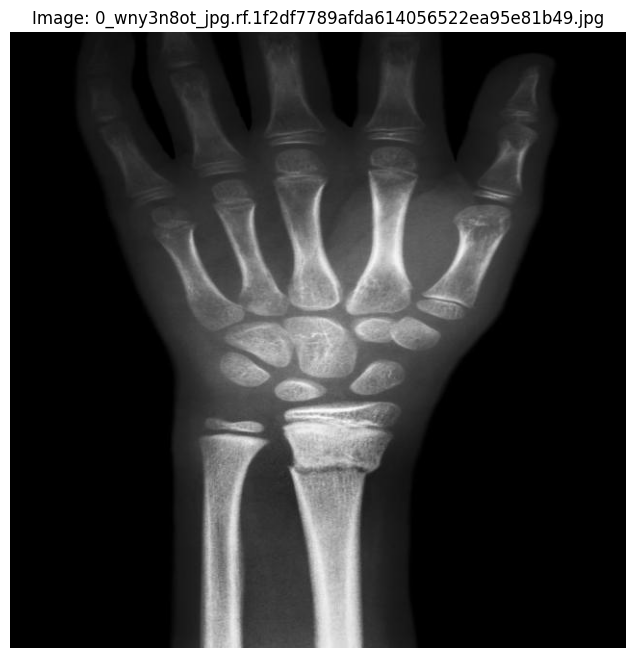

In [4]:
import cv2
import matplotlib.pyplot as plt

# Function to display an image
def show_image(image_path):
    """
    Display an image using Matplotlib.
    Args:
        image_path (str): Path to the image file.
    """
    image = cv2.imread(image_path)  # Load the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.show()

# Show the first image in the dataset
sample_image_path = os.path.join(images_path, image_files[0])
show_image(sample_image_path)


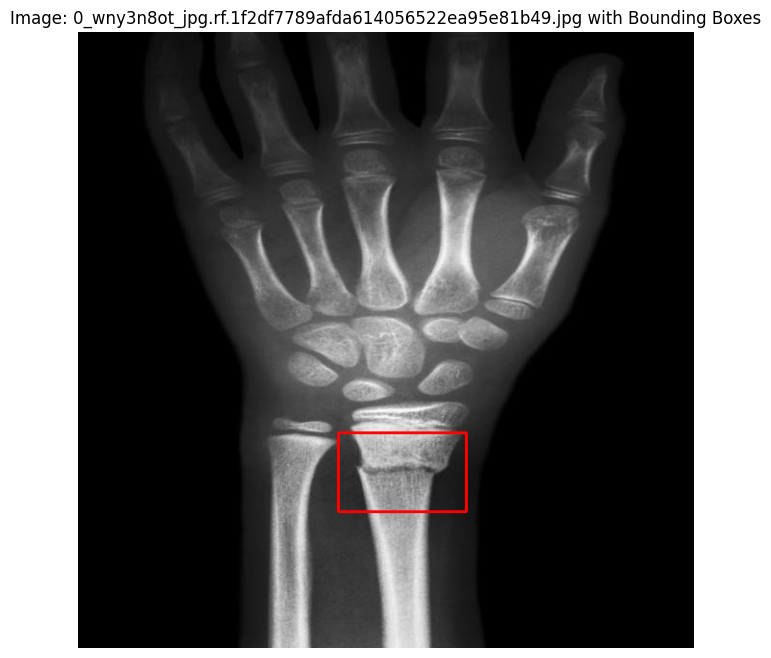

In [5]:
def load_yolo_annotations(txt_file, image_width, image_height):
    """
    Load YOLO annotations and convert them to pixel coordinates.
    Args:
        txt_file (str): Path to the YOLO `.txt` annotation file.
        image_width (int): Width of the image in pixels.
        image_height (int): Height of the image in pixels.
    Returns:
        List of bounding boxes in pixel coordinates.
        Each box: (class_id, x_min, y_min, width_pixel, height_pixel)
    """
    boxes = []
    with open(txt_file, 'r') as f:
        for line in f:
            data = line.strip().split()
            class_id = int(data[0])  # Class ID (optional for now)
            x_center, y_center, width, height = map(float, data[1:])

            # Convert normalized YOLO coordinates to pixel coordinates
            x_center_pixel = int(x_center * image_width)
            y_center_pixel = int(y_center * image_height)
            width_pixel = int(width * image_width)
            height_pixel = int(height * image_height)

            # Calculate top-left corner
            x_min = int(x_center_pixel - width_pixel / 2)
            y_min = int(y_center_pixel - height_pixel / 2)
            boxes.append((class_id, x_min, y_min, width_pixel, height_pixel))
    return boxes


def visualize_image_with_boxes(image_path, annotation_path):
    """
    Visualize an image with YOLOv8 bounding boxes.
    Args:
        image_path (str): Path to the image file.
        annotation_path (str): Path to the YOLO annotation file.
    """
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image_height, image_width = image.shape[:2]

    # Load YOLO annotations
    boxes = load_yolo_annotations(annotation_path, image_width, image_height)

    # Draw bounding boxes on the image
    for box in boxes:
        class_id, x_min, y_min, width_pixel, height_pixel = box
        # Draw rectangle (bounding box)
        cv2.rectangle(image, (x_min, y_min), (x_min + width_pixel, y_min + height_pixel), color=(255, 0, 0), thickness=2)

    # Display the image with bounding boxes
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.title(f"Image: {os.path.basename(image_path)} with Bounding Boxes")
    plt.show()

# Test the visualization with the first image and annotation
sample_image_path = os.path.join(images_path, image_files[0])
sample_label_path = os.path.join(labels_path, os.path.splitext(image_files[0])[0] + '.txt')
visualize_image_with_boxes(sample_image_path, sample_label_path)
